# Practice Session PS05: Recommendation engines (Content-based)

For this assignment we will build and use a content-based recommender system for movies. This content-based recommender will take as input a database of users and ratings on movies.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Shaoya Zhang</font>

E-mail: <font color="blue">shaoya.zhang01@estudiant.upf.edu</font>

Date: <font color="blue">2025-10-30</font>

# 0. The Movies dataset

One of the most widely used datasets for video/movies recommendation is the one built by the University of Minnesota, known as the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). In this assignment we are going to use the 32M version, which was released in 2024.

We will use a sub-set containing only movies released in the 2000s, and only 10% of the users and all of their ratings.

**MOVIES** are described in `ml32m-movies-2000s.csv.gz` in the following format: `movieId,title,genres`.

- Titles include the year of release in paranthesis, the year is greater or equal to 2000
- Genres are pipe-separated ("|") and are selected from the following genres: 'Musical', 'Horror', 'Comedy', 'Crime', 'Western', 'Sci-Fi', 'Documentary', 'Adventure', 'IMAX', 'Drama', 'Fantasy', 'Children', 'War', 'Thriller', 'Mystery', 'Action', 'Romance', 'Film-Noir', 'Animation' or '(no genres listed)'.

**RATINGS** are contained in `ml32m-ratings-2000s.csv.gz` in the following format: `userId,movieId,rating`

- Ratings are made on a 5-star scale
- This has been filtered to contain only movies released in the 2000s, and to sample 20% of rows

**TAGS** are contained in `ml32m-tags-2000s.csv.gz` in the following format: `userId,movieId,tag`

- Tags are words or short phrases, they are user-generated and can be anything

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [1]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

The following code, which you should leave as-is, loads the 3 dataset within three dataframes named `movies`,  `ratings` and `tags` considering the data structure explained above.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [3]:
# Leave this code as-is

FILENAME_MOVIES = "ml32m-movies-2000s.csv.gz"
FILENAME_RATINGS = "ml32m-ratings-2000s.csv.gz"
FILENAME_TAGS = "ml32m-tags-2000s.csv.gz"

In [4]:
# LEAVE THIS CODE AS-IS

# Load movies
movies = pd.read_csv(FILENAME_MOVIES, 
                    compression='gzip',
                    sep=',', 
                    engine='python', 
                    encoding='utf-8',
                    names=['movie_id', 'title', 'genres'])

# Remove header row from this file
movies.drop(index=0, inplace=True)

# Make sure the movie id is numeric
movies["movie_id"] = pd.to_numeric(movies["movie_id"])
display(movies.head(5))

,movie_id,title,genres
1,2769,"Yards, The (2000)",Crime|Drama
2,3177,Next Friday (2000),Comedy
3,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
4,3225,Down to You (2000),Comedy|Romance
5,3228,Wirey Spindell (2000),Comedy


In [5]:
# LEAVE THIS CODE AS-IS

# Load ratings
ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    compression='gzip',
                    encoding='utf-8',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating'])
display(ratings_raw.head(5))

,user_id,movie_id,rating
0,4,223,4.0
1,4,1210,3.0
2,4,1272,4.0
3,4,1327,3.0
4,4,1513,2.0


Next we will add a column named "year" to the `movies` dataset.

First, create a function `yearof()` that returns the year of a title as an integer, for instance:

```python
print(yearof("The Emoji Movie (2017)"))
```

Should return the integer *2017*. Then, you can apply this function to the entire dataframe.

If you have a function named *f* that takes the column *a* of dataframe *df*, and produces a value you want to store in column *b* of the same dataframe, you can use:

```python
df['b'] = df.apply(lambda x: f(x['a']), axis=1)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your own code to add a `year` column to the `movies` dataframe.</font>

In [6]:
def yearof(text):
    match = re.search(r"\((\d{4})\)", text)
    if match:
        return int(match.group(1))
    else:
        return None

movies['year'] = movies['title'].apply(yearof)
display(movies.tail(5))

,movie_id,title,genres,year
51440,292709,End of the Season (2017),Drama,2017
51441,292731,The Monroy Affaire (2022),Drama,2022
51442,292737,Shelter in Solitude (2023),Comedy|Drama,2023
51443,292753,Orca (2023),Drama,2023
51444,292757,Race to the Summit (2023),Action|Adventure|Documentary,2023


Next we will join the dataframes into a single dataframe named "ratings". The equivalent of the database *join* that you learned in databases is [pandas.merge](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) in Pandas, and it requires to identify common columns between the inputs that need to be joined. 

Suppose you have dataframes A and B that share column x. You can use this to create a dataframe C joining them on column x:

```python
C = pd.merge(A, B, how='inner', on='x')
```

There the `on` parameter should indicate the name of the common column. There are other ways of merging, this is the simplest case.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with a brief commentary indicating on which field you can join ratings_raw and movies.</font>

## Answer
We can join ratings_raw and movies on movie_id since it is the common column these two dataframes share.

<font size="+1" color="red">Replace this cell with your own code to join the datasets into a single dataframe named "ratings". Your dataframe should have the following columns: user_id, movie_id, rating, title, genders, year</font>

In [7]:
df_ratings_movies = pd.merge(movies, ratings_raw, how='inner', on='movie_id')
display(df_ratings_movies.head(10))

,movie_id,title,genres,year,user_id,rating
0,2769,"Yards, The (2000)",Crime|Drama,2000,365,4.0
1,2769,"Yards, The (2000)",Crime|Drama,2000,6965,1.0
2,2769,"Yards, The (2000)",Crime|Drama,2000,12489,4.0
3,2769,"Yards, The (2000)",Crime|Drama,2000,13946,4.0
4,2769,"Yards, The (2000)",Crime|Drama,2000,22141,2.0
5,2769,"Yards, The (2000)",Crime|Drama,2000,24216,1.5
6,2769,"Yards, The (2000)",Crime|Drama,2000,25384,3.0
7,2769,"Yards, The (2000)",Crime|Drama,2000,26651,3.0
8,2769,"Yards, The (2000)",Crime|Drama,2000,27418,3.0
9,2769,"Yards, The (2000)",Crime|Drama,2000,30157,4.0


Create a function `find_movies` to easily find movies that contain a given keyword in its title. For instance `find_movies("Barcelona", movies)` should print:

```
movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)
```

*Tip:* to know if string *a* is contained in string *b*, you can ask `if a in b`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for find _movies</font>

In [8]:
def find_movies(keyword, df):
    for _, row in df.iterrows():
        if keyword.lower() in row['title'].lower():
            print(f"movie_id: {row['movie_id']}, title: {row['title']}")
            
find_movies("Barcelona", movies)


movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)
movie_id: 213736, title: Barcelona Summer Night (2013)
movie_id: 259761, title: The Barcelona Vampiress (2020)
movie_id: 288765, title: Bird Box Barcelona (2023)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

To have a clear understanding of the data, it is key to know the distribution of the main variables.
With the **.describe** function of Pandas, we can get a summary of the main statistics of a numeric variable:

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [9]:
# LEAVE AS-IS

ratings_raw['rating'].describe()

count    2.671536e+06
mean     3.556416e+00
std      1.056151e+00
min      5.000000e-01
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

It is key to know how ratings are distributed. Generate a plot with the ditribution of the ratings. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating. Remember to label both axes.</font>

Text(0, 0.5, 'Probability')

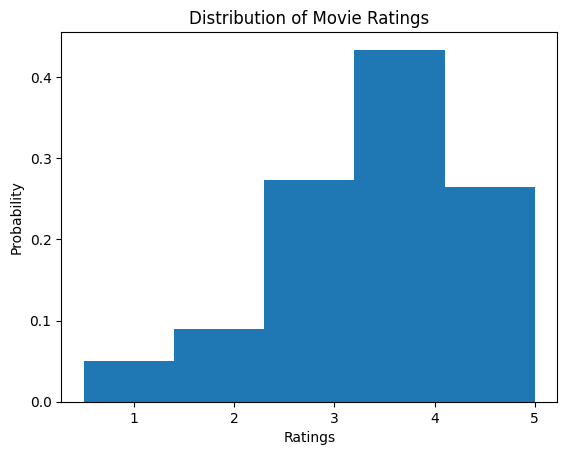

In [10]:
plt.figure()
plt.hist(ratings_raw['rating'], bins=5, density=True)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Ratings")
plt.ylabel("Probability")

<font size="+1" color="red">Replace this cell with your code to plot a boxplot of ratings. Look for outlier values. </font>

{'whiskers': [<matplotlib.lines.Line2D at 0x23912ef5bd0>,
 'caps': [<matplotlib.lines.Line2D at 0x23912ef5e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x23912ef5a90>],
 'medians': [<matplotlib.lines.Line2D at 0x23912ef60d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x23912ef6210>],
 'means': []}

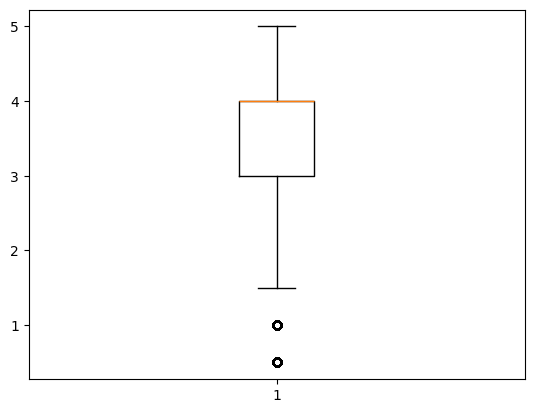

In [11]:
plt.boxplot(ratings_raw['rating'], vert=True)

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the distribution of ratings.</font>

## Answer


Now let us find out two extrema: movies with many good ratings and movies with many bad ratings.

For this, a good idea is to find create a different dataframe. For instance, you can create `good_ratings`, containing only the subset of rows of `ratings` that has *rating > 4.0*, and `bad_ratings` containing only the subset that has *rating < 2.0*.

Then, you just need to count what are the most frequent titles in `good_ratings`. There are many ways to do this, one is by using [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and [nlargest](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html), but there are other ways.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are equal to 5.0), and the 10 movies with the most "bad" ratings (i.e., ratings than are equal to 1.0)</font>

In [12]:
movies_best = df_ratings_movies[df_ratings_movies['rating'] == 5.0]['title'].value_counts().nlargest(10)
print("\n======================10 best 5-star rating movies======================")
print(movies_best.head(10))
movies_worst = df_ratings_movies[df_ratings_movies['rating'] == 1.0]['title'].value_counts().nlargest(10)
print("\n======================10 worst 1-star rating movies======================")
print(movies_worst.head(10))



======================10 best 5-star rating movies======================
title
Lord of the Rings: The Fellowship of the Ring, The (2001)    2677
Lord of the Rings: The Return of the King, The (2003)        2468
Lord of the Rings: The Two Towers, The (2002)                2304
Memento (2000)                                               1560
Gladiator (2000)                                             1442
Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)        1376
Spirited Away (Sen to Chihiro no kamikakushi) (2001)         1297
Eternal Sunshine of the Spotless Mind (2004)                 1213
Kill Bill: Vol. 1 (2003)                                      997
Shrek (2001)                                                  932
Name: count, dtype: int64

======================10 worst 1-star rating movies======================
title
Star Wars: Episode II - Attack of the Clones (2002)          178
Battlefield Earth (2000)                                     175
Charlie's Angels (2000)

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in these lists.</font>

## Answer


## 2.2. Genres distribution

Tipically, a movie genre (e.g., "musical", "action", "romance") is one of the most important descriptor for a movie recommendation engine: a basic assumption is that films in the same genre should have similar contents. Because of this, we have to know how this variable is, i.e. the values or categories, number or ratio of each categories, and so on.

Create a table indicating the list of all genres (column `movie['genres']` in this dataset).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to list all genres in the dataset. Verify the list has 20 genres with an assert, as follows:
    assert(n == 20).</font>

In [ ]:
# genres
all_genres_flat = [g for sublist in movies['genres'].str.split('|') for g in sublist]
genre_labels = pd.DataFrame({'genre': list(set(all_genres_flat))})
assert(len(genre_labels) == 20)
display(genre_labels)

,genre
0,Children
1,Musical
2,Sci-Fi
3,Thriller
4,(no genres listed)
5,Mystery
6,Action
7,Western
8,Comedy
9,Romance


Print a list of the genres you see in this dataset, sorted from the most frequent to the least frequent, and indicating the average rating of movies containing that genre. Notice that these frequencies may add up to more than the number of movies in the dataset, as a movie may have more than one genre.

Your output should be contained in dataframe `genre_count_avg_rating`, and should look similar to this:

```
  genre       count  avg_rating
0 Drama       20069  3.63
1 Comedy      13384  3.35
2 Thriller     8079  3.51
3 Documentary  7583  3.60
...
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre in the dataset, check that it returns the same result as above. Create a function `calc_genre_count_avg_rating()` that receives all relevant arguments, i.e, is invoked as `calc_genre_count_avg_rating(movies, 'genres', genre_labels, ratings)` and returns a dataframe with *genre, count, avg_rating* columns. Feel free to use auxiliary functions.</font>

In [ ]:
# def calc_genre_count_avg_rating(df, feature, labels, ratings):
#     rating_sum = {}
#     count = {}
#     avg_rating = {}
#     for label in labels:
#         count[label] = 0
#         rating_sum[label] = 0
#         for _, row in df.iterrows():
#             movie_genres = str(row[feature]).split('|')
#             if label in movie_genres:
#                 rating_sum[label] += row[ratings]
#                 count[label] += 1
#         avg_rating[label] = rating_sum[label] / count[label] if count[label] > 0 else 0
#     movies_rating_stats = pd.DataFrame({'genre':labels, 
#                                         'count': [count[l] for l in labels],
#                                         'avg_rating': [round(avg_rating[l], 2) for l in labels]})
#     movies_rating_stats = movies_rating_stats.sort_values(by='count', ascending=False).reset_index(drop=True)
#     return movies_rating_stats

In [30]:
def calc_genre_count_avg_rating(movies, feature, labels, ratings):

    # Merge movies and ratings
    df = pd.merge(movies, ratings, on='movie_id', how='inner')

    # Explode genres
    df['genre'] = df[feature].str.split('|')
    df_exploded = df.explode('genre')

    # 3️⃣ 按 genre 统计评分次数和平均评分
    genre_stats = (
        df_exploded.groupby('genre')['rating']
        .agg(count='count', avg_rating='mean')
        .reset_index()
    )

    # 4️⃣ 四舍五入 + 排序
    genre_stats['avg_rating'] = genre_stats['avg_rating'].round(2)
    genre_stats = genre_stats.sort_values(by='count', ascending=False).reset_index(drop=True)

    return genre_stats


In [31]:
# LEAVE THIS CODE AS-IS

genre_count_avg_rating = calc_genre_count_avg_rating(movies, 'genres', genre_labels['genre'], ratings_raw)
genre_count_avg_rating

,genre,count,avg_rating
0,Drama,318210,3.63
1,Comedy,256395,3.35
2,Action,230782,3.43
3,Thriller,224786,3.51
4,Adventure,206969,3.54
5,Romance,137872,3.51
6,Crime,126516,3.60
7,Sci-Fi,112165,3.40
8,Fantasy,110898,3.61
9,Mystery,73589,3.64


<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the previous table, particularly what are the genres with the best/worst ratings, and why do you believe that happens.</font>

## Answer
Looking at the table, Film-Noir, Mystery, Fantasy, Crime, and Documentary have the highest average ratings, with Film-Noir at 3.79 being the top. Conversely, Horror and Western have the lowest average ratings, at 3.16 and 3.29 respectively. This pattern suggests that audiences tend to rate niche or specialized genres more favorably, while genres like Horror and Western are more polarizing or less universally appealing.

Let us look at the distribution of genres. Create a **horizontal barplot** in which bars are horizontal, genres are in the Y axis from most common (top) to least common (bottom), and the horizontal length of the bar indicates the number of movies.

You can use [seaborn.barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) for this:

```python
ax = sns.barplot(genre_count, x=..., y=..., orient=...)
```

Remember to use `ax.set` to set a title, xlabel, and ylabel for your plot.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to produce two bar plots: one for movies filmed on 2010 or before, and another for movies filmed on 2020 or later.</font>

C:\Users\zsy\AppData\Local\Temp\ipykernel_24980\3575403959.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


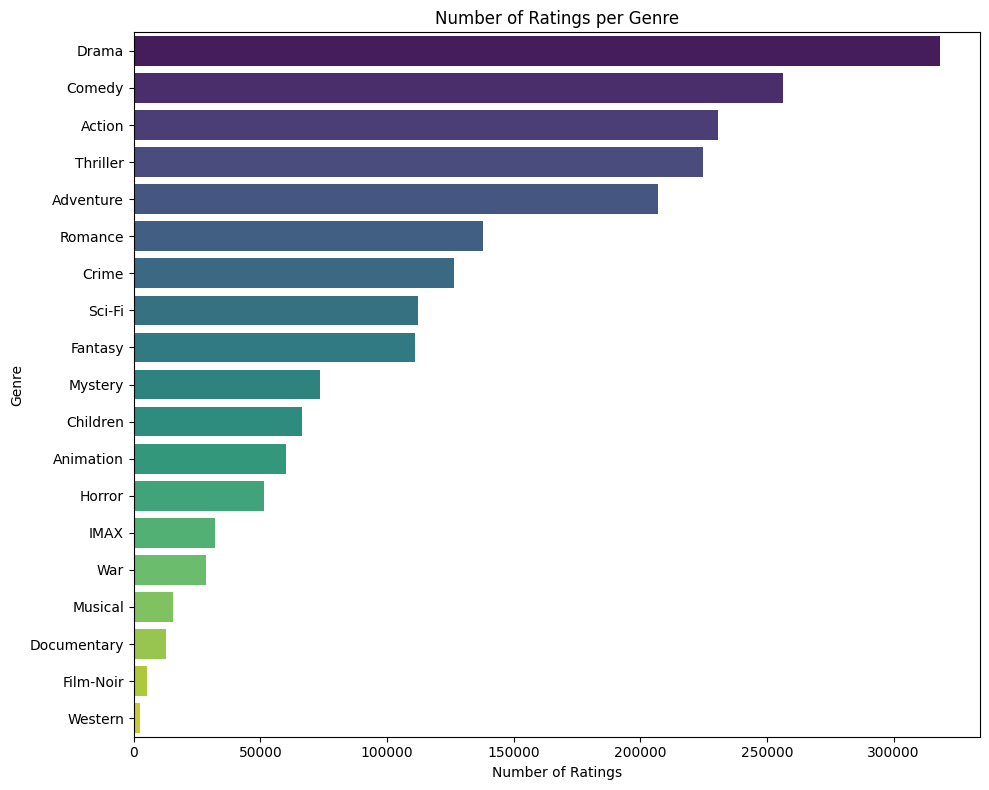

In [32]:
# Sort genres from most common to least common
genre_plot_data = genre_count_avg_rating.sort_values(by='count', ascending=False)

# Create horizontal barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x='count', 
    y='genre', 
    data=genre_plot_data, 
    orient='h',  # horizontal bars
    palette='viridis'
)

# Set title and axis labels
ax.set(
    title='Number of Ratings per Genre',
    xlabel='Number of Ratings',
    ylabel='Genre'
)

plt.tight_layout()
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary comparing both distributions, including which genres changed popularity.</font>

## Answer
The genres with the highest average ratings are Film-Noir (3.79), Mystery (3.64), Fantasy (3.61), Crime (3.60), and Documentary (3.60), while the lowest rated genres are Horror (3.16), Western (3.29), Comedy (3.35), and Sci-Fi (3.40). Notably, some popular genres like Comedy and Action are moderate in ratings despite high counts, whereas niche genres like Film-Noir and Mystery receive the highest ratings despite having few movies. This shows that less frequent genres are often more appreciated by their audiences, while mainstream genres attract more viewers but do not always achieve top ratings.

# 3. Content-based recommendation

A content-based recommender works with data that describes the movie (or content). In our case, we will mainly use the genres that describes each movie. Our assumption is that films in the same genres should have similar contents and therefore are more likely to be recommended.

We *could* extend the content-based taking into account the title or any other text-based characteristics of the movie. We could also extend it using other attributes of the movie, even if they are not text. Content-based recommendations just means that we somehow compute the similarity between the items and then recommend the most similar items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 3.1. Compute TF-IDF vectors

**Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are techniques used in information retrieval to determine the **importance** of a word. In our use case, content-based recommendation, TF-IDF will be used to measure the importance of each genre in each movie. 

TF is simply the frequency of a word in a document, IDF is the inverse of the document frequency among the whole corpus of documents. Usually, TF and IDF are combined to measure the relevance of a word or term across different documents.

In a nutshell, TF-IDF weights infrequent words (in our case genres) more heavily. This means that two movies that share many uncommon genres will be considered more similar than two movies that share many common genres.

The TF-IDF score is computed as:

**tfidf(keyword, document) = TF(keyword, document) x IDF(keyword)**

Where:

* **TF(keyword, doc)** is the number of times the *keyword* appears in the *document*
* **IDF(keyword)** is **log(N/docfreq(keyword))** where **N** is the total number of documents and **docfreq(keyword)** is the number of documents containing the **keyword**

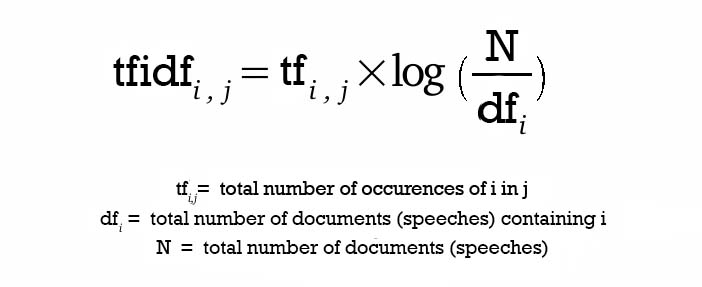

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

As a movie can belong to several genres, you should first break up the genre string into a string array.

Create a new column `genres_arr` in dataframe `movies` that contains the genres splitted in character "|".

Ensure this column has no "NaN", using [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html). Example: `df['colname'].fillna('').astype('str')`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to add column "genres_arr" to the dataframe "movies".</font>

Verify by running the next cell. It should print:

```
Transformed: Comedy|Romance → ['Comedy', 'Romance']
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE THIS CODE AS-IS

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Now we will work with a smaller part of the data. Define `movies_filtered` as all the movies filmed on 2020 or later.

Use the [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute tf-idf vectors on this column. Use `ngram_range=(1,2)` to consider one- and two-word genres. Store the resulting vectors in `tfidf_matrix`.

The resulting matrix should have 7986 rows and 126 columns. Verify this using `tfidf_matrix.shape`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE THIS CODE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year >= 2020]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

<font size="+1" color="red">Replace this cell with your code to generate "tfidf_matrix"</font>

## 3.2. Calculate most similar movies

As previously explained, the calculated TF-IDF from **genre** will be the variable to describe the content; i.e. in our case, the movie. 
The **similarity** will be measured considering the angle between the vectors generated after the TF-IDF process. Each movie becomes a vector of attributes in an **n-dimensional space** where the angles between the vectors **determines the similarity**. 
The method of calculating this relative measure is taking the cosine of the angle between two vectors. The vectors are length normalized and then the cosine calculation is simply the sum-product of vectors. 

For a more generic perspective, the next image is an example of several sentences represented by its vector space where Sentence 2 is more likely to be using Term 2 than using Term 1.

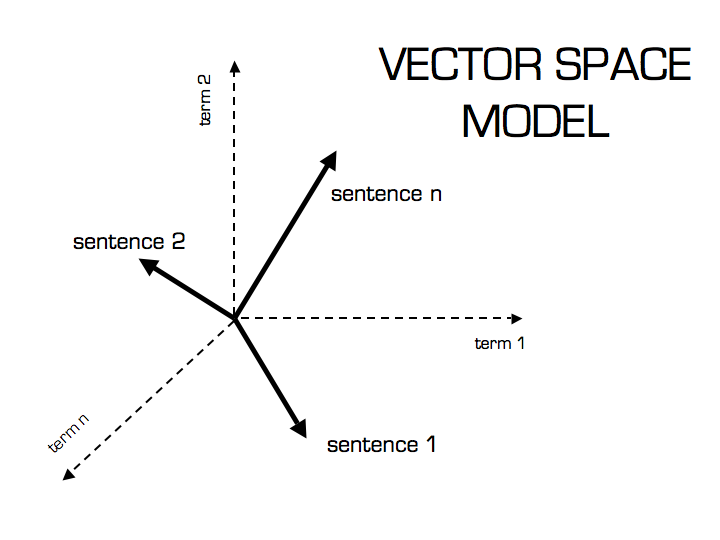

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The next code, which you should leave as-is, uses sklearn's [linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html) function, which is a fast way of computing these similarities on a matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [33]:
# LEAVE THIS CODE AS-IS

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

NameError: name 'tfidf_matrix' is not defined

It is easy at this point to confuse movie_ids with row numbers. The following code, which you should leave as-is, will be helpful to you as it shows you how to obtain a row/column in this similarity matrix, and then how to go back to movie_ids from row/column numbers.

In this example, we ask for the similarities of all movies to movie with id 1 which is "Toy Story (1995)".

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE THIS CODE AS-IS

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))

# Test with the movie: "Gretel & Hansel (2020)"
print_similarity_vector(210455, cosine_sim)

Create a function `genre_content_based_recommendations` that uses the similarity matrix and the list of movie titles to find the top-k most recommended movies for a given movie.

Python's `enumerate` function will be helpful. Look at the following example:

```python
similarities = [0.2, 0.7, 0.3, 0.4]
enumerated = list(enumerate(similarities))
sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
top_two_similarities = sorted_similarities[0:2]
for index, similarity in top_two_similarities:
    print("Element #%d with similarity %.1f" % (index, similarity))
```

The output will be: 

```
Element #1 with similarity 0.7
Element #3 with similarity 0.4
```

The function `genre_content_based_recommendations` should follow this template:

```python
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain recom_movie_id, title, genres
        
        recommendations.append({
                'movie_id': movie_id,           # Original movie
                'recom_movie_id': rec_movie_id, # Movie that is recommended
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations,
                                     columns=['movie_id', 'recom_movie_id', 'similarity', 'title', 'genres'])
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "genre_content_based_recommendations"</font>

In [ ]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain recom_movie_id, title, genres
        
        recommendations.append({
                'movie_id': movie_id,           # Original movie
                'recom_movie_id': rec_movie_id, # Movie that is recommended
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations,
                                     columns=['movie_id', 'recom_movie_id', 'similarity', 'title', 'genres'])

<font size="+1" color="red">Replace this cell with code to print the top 10 recommendations for movie "Oxygen (2021)" and "PAW Patrol: The Movie (2021)".</font>

<font size="+1" color="red">Replace this cell with code to get a list of 15 recommendations for each of 3 movies you are familiar with. Indicate the **precision** of each list, which is the percentage of recommended movies that *you* consider relevant among the 15 (mark manually as "relevant" or "irrelevant" each recommendation). Indicate the **average precision** across the three lists.</font> 

<font size="+1" color="red">Replace this cell with **two** ideas on how you would improve **this** content-based recommendations, based on what we discussed in class about content-based recommendations. Name them "Idea 1" and "Idea 2".</font>

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, use the user-defined tags defined in the `ml32m-tags-2000s.csv.gz` file, in the same way in which you used movie genres. This is a large file, so **filter aggressively** (e.g., consider less movies, impose a minimum document frequency when doing the tf-idf vectorization, and so on).

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: tags</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that I completed this practice myself, that my answers were not written by an AI-enabled code assistant, and that except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>